# Document embedding (via doc2vec) + classifier

In [1]:
import ast
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random 
import seaborn as sns

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from google.colab import drive
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2

In [2]:
drive.mount('/content/drive', force_remount=True)
path = '/content/drive/My Drive/DS4A-Project/Data/political_news/'

Mounted at /content/drive


# 1. Load data & split

In [3]:
df_BERT = pd.read_csv(path + "BERT_data2.csv")
df = pd.read_csv(path + "cleaned_data2.csv")
df_fake = pd.read_csv(path + "Fake.csv")
n_doc = df_BERT.shape[0]
n_fake = df_fake.shape[0]

In [ ]:
# prepare text for Doc2Vec
total_text = df_BERT["title_text_BERT"].apply(lambda x: [item.lower() for item in x.split()])
#total_text = df["title_text_stemmed"].apply(ast.literal_eval)

In [ ]:
# split to train, test, CV
indices = list(range(n_doc))
random.shuffle(indices)
train_idx = indices[:int(n_doc*0.7)]
cv_idx = indices[int(n_doc * 0.7):int(n_doc * 0.85)]
test_idx = indices[int(n_doc * 0.85):]
print(len(train_idx))
print(len(cv_idx))
print(len(test_idx))

train_idx.sort()
cv_idx.sort()
test_idx.sort()

# save indices
#f = h5py.File("/content/drive/My Drive/DS4A-Project/Code/doc2vec/train_val_test.hdf5", "w")
#f.create_dataset("train_idx", data = train_idx)
#f.create_dataset("cv_idx", data = cv_idx)
#f.create_dataset("test_idx", data = test_idx)
#f.close()

31428
6735
6735


In [ ]:
# open indices for train, CV, test set
f = h5py.File("/content/drive/My Drive/DS4A-Project/Code/doc2vec/train_val_test.hdf5", 'r')
train_idx = list(f["train_idx"])
cv_idx = list(f["cv_idx"])
test_idx = list(f["test_idx"])
f.close()

# 2. Train doc2vec

## 2(a) Train doc2vec on training data only

In [ ]:
train_text = [total_text[i] for i in train_idx]
#total_doc = [TaggedDocument(doc, [i]) for i, doc in enumerate(total_text)]
train_doc = [TaggedDocument(doc,[i]) for i,doc in enumerate(train_text)]


In [ ]:
# train doc2vec model
model = Doc2Vec(vector_size=300, dm = 1, window=10, min_count=3, epochs =50)
model.build_vocab(train_doc)
model.train(train_doc, total_examples=model.corpus_count, epochs=model.epochs)
#model.save("/content/drive/My Drive/DS4A-Project/Code/doc2vec/train_doc2vec.model")

In [ ]:
model.docvecs.vectors_docs.shape

(31428, 300)

## 2(b) Visualize doc2vec embeddings

In [ ]:
# load trained model
model = Doc2Vec.load("/content/drive/My Drive/DS4A-Project/Code/doc2vec/train_doc2vec.model") 

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Visualize training set embedding

In [ ]:
# get samples from training set
sampled_idx = random.sample(train_idx, 700)

fake_idx = [i for i in range(700) if sampled_idx[i] < n_fake]
real_idx = [i for i in range(700) if sampled_idx[i] >= n_fake]

# get sample doc embedding
doc_embedding = np.zeros((700, 300))
for idx, i in enumerate(sampled_idx):
  #new_idx = train_idx.index(i)
  #doc_embedding[idx,:] = model.docvecs[new_idx]
  doc_embedding[idx,:] = model.infer_vector(total_text[i], epochs = 50)

In [ ]:
# pca
pca = PCA(n_components = 2)
X_transformed = pca.fit_transform(doc_embedding)

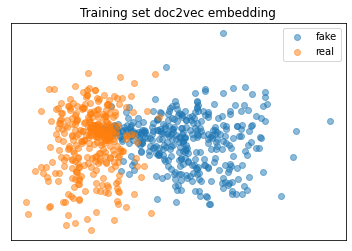

In [ ]:
plt.scatter(X_transformed[fake_idx,0],X_transformed[fake_idx,1], label ="fake", alpha = 0.5)
plt.scatter(X_transformed[real_idx,0], X_transformed[real_idx,1], label= "real", alpha =0.5)
plt.legend()
plt.xticks([])
plt.yticks([])
plt.title("Training set doc2vec embedding")
plt.show()


Embedding of sample CV

In [ ]:
# get random samples of cv 
random.shuffle(cv_idx)
sampled_idx = random.sample(cv_idx, 700)

fake_idx = [i for i in range(700) if sampled_idx[i] < n_fake]
real_idx = [i for i in range(700) if sampled_idx[i] >= n_fake]

# get vectors of sampled doc
doc_embedding = np.zeros((700, 300))
for idx, i in enumerate(sampled_idx):
  doc_embedding[idx,:] = model.infer_vector(total_text[i], epochs = 50)

In [ ]:
# pca
pca = PCA(n_components = 2)
X_transformed = pca.fit_transform(doc_embedding)

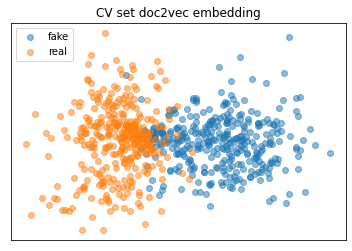

In [ ]:
plt.scatter(X_transformed[fake_idx,0],X_transformed[fake_idx,1], label ="fake", alpha = 0.5)
plt.scatter(X_transformed[real_idx,0], X_transformed[real_idx,1], label= "real", alpha =0.5)
plt.legend()
plt.xticks([])
plt.yticks([])
plt.title("CV set doc2vec embedding")
plt.show()

## 2(c) Vectorize all documents

In [ ]:
# prepare data
X = np.zeros((n_doc,300))

# get vectors
for i in range(n_doc):
  X[i,:] = model.infer_vector(total_text[i], epochs = 50)

# save vectors
#f = h5py.File("/content/drive/My Drive/DS4A-Project/Code/doc2vec/doc2vec_embeddings.hdf5", "w")
#f.create_dataset("X", data = X)
#f.close()

# 3. Build classifier 

## 3(a) logistic regression

In [ ]:
# load data
df_BERT = pd.read_csv(path + "BERT_data2.csv")
df_fake = pd.read_csv(path + "Fake.csv")
n_doc = df_BERT.shape[0]
n_fake = df_fake.shape[0]

f = h5py.File("/content/drive/My Drive/DS4A-Project/Code/doc2vec/doc2vec_embeddings.hdf5", "r")
X = np.array(f["X"])
f.close()

# open indices for train, CV, test set
f = h5py.File("/content/drive/My Drive/DS4A-Project/Code/doc2vec/train_val_test.hdf5", 'r')
train_idx = list(f["train_idx"])
cv_idx = list(f["cv_idx"])
test_idx = list(f["test_idx"])
f.close()

random.shuffle(train_idx)
random.shuffle(cv_idx)

X_train = X[train_idx,:]
X_cv = X[cv_idx,:]
X_test = X[test_idx,:]

y_train = df_BERT["fake_flag"][train_idx]
y_cv = df_BERT["fake_flag"][cv_idx]
y_test = df_BERT["fake_flag"][test_idx]

In [ ]:
model = Sequential()
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics = ['accuracy'])

In [ ]:
# train
callback = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(X_train, y_train, epochs=50, verbose=1, validation_data=(X_cv, y_cv), callbacks = [callback])

Epoch 1/50
983/983 [==============================] - 2s 2ms/step - loss: 0.2936 - accuracy: 0.8794 - val_loss: 0.1742 - val_accuracy: 0.9393
Epoch 2/50
983/983 [==============================] - 2s 2ms/step - loss: 0.1708 - accuracy: 0.9405 - val_loss: 0.1572 - val_accuracy: 0.9442
Epoch 3/50
983/983 [==============================] - 2s 2ms/step - loss: 0.1572 - accuracy: 0.9445 - val_loss: 0.1542 - val_accuracy: 0.9431
Epoch 4/50
983/983 [==============================] - 2s 2ms/step - loss: 0.1515 - accuracy: 0.9455 - val_loss: 0.1522 - val_accuracy: 0.9445
Epoch 5/50
983/983 [==============================] - 2s 2ms/step - loss: 0.1483 - accuracy: 0.9466 - val_loss: 0.1531 - val_accuracy: 0.9430
Epoch 6/50
983/983 [==============================] - 2s 2ms/step - loss: 0.1464 - accuracy: 0.9469 - val_loss: 0.1538 - val_accuracy: 0.9434
Epoch 7/50
983/983 [==============================] - 2s 2ms/step - loss: 0.1451 - accuracy: 0.9464 - val_loss: 0.1539 - val_accuracy: 0.9433
Epoch 

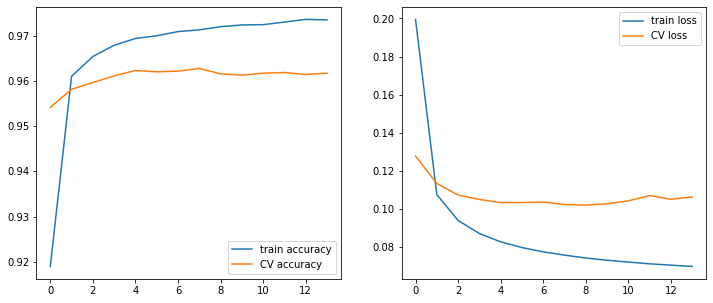

In [ ]:
fig, ax = plt.subplots(ncols = 2, figsize = (12, 5))

ax[0].plot(history.history["accuracy"], label = "train accuracy")
ax[0].plot(history.history["val_accuracy"], label = "CV accuracy")
ax[0].legend()

ax[1].plot(history.history["loss"], label = "train loss")
ax[1].plot(history.history["val_loss"], label = "CV loss")
ax[1].legend()
plt.show()

In [ ]:
# we'll use the model after training for 5 epochs
model = Sequential()
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics = ['accuracy'])

history = model.fit(X_train, y_train, epochs=5, verbose=0, validation_data=(X_cv, y_cv))

Text(0.5, 1.0, 'Confusion matrix on test set')

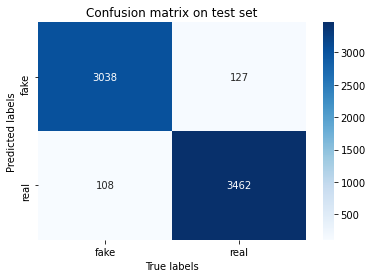

In [ ]:
test_pred = (model.predict(X_test) > 0.5).astype("int32")
cf_matrix = confusion_matrix(y_test, test_pred)

ax = plt.subplot()
sns.heatmap(cf_matrix, annot = True, fmt ="d",cmap ='Blues', ax = ax)

ax.set_xlabel("True labels")
ax.set_ylabel("Predicted labels")
ax.xaxis.set_ticklabels(["fake","real"])
ax.yaxis.set_ticklabels(["fake","real"])
ax.set_title("Confusion matrix on test set")

In [ ]:
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      3165
           1       0.96      0.97      0.97      3570

    accuracy                           0.97      6735
   macro avg       0.97      0.96      0.96      6735
weighted avg       0.97      0.97      0.97      6735



In [ ]:
# ROC curve & AUC
test_prob = model.predict(X_test)
FPR , TPR , thresholds = roc_curve( y_test, test_prob)
auc_score=roc_auc_score(y_test, test_prob)
print("AUC score:" , auc_score)

AUC score: 0.994740000265509


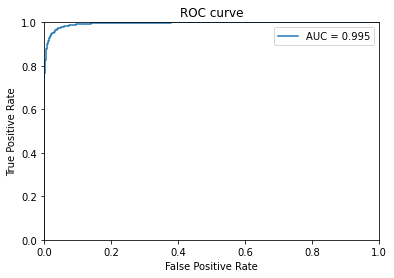

In [ ]:
plt.plot(FPR,TPR, label ="AUC = %.3f" %auc_score) 
plt.axis([0,1,0,1]) 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.legend()
plt.title("ROC curve")
plt.show()    

Misclassified examples

In [ ]:
y_test_list = y_test.tolist()
test_pred_list = [item[0] for item in test_pred.tolist()]

In [ ]:
n_test = len(y_test_list)
fake_misclassified = [i for i in range(n_test) if (y_test_list[i] == 1) & (test_pred_list[i] == 0) ]
real_misclassified = [i for i in range(n_test) if (y_test_list[i] == 0) & (test_pred_list[i] == 1)]

In [ ]:
# 5 example fake news classified as real
fake_sample = random.sample(fake_misclassified, 5)
print("#### Example fake news misclassified as real news ####")
for i in fake_sample:
  print(df_BERT.at[test_idx[i],"title_text_BERT"])

# 5 example real news classified as fake
real_sample = random.sample(real_misclassified, 5)
print("#### Example real news misclassified as fake news ####")
for i in real_sample:
  print(df_BERT.at[test_idx[i],"title_text_BERT"])


#### Example fake news misclassified as real news ####
HYSTERICAL! JESSE WATTERS Busts The Idiotic “White Privilege” Trend On Campus: “I don’t necessarily feel it” [Video].  .
JUDGE JEANINE IS FURIOUS! “Hillary Won’t Stop Lying!” [VIDEO]. Can you blame her for losing her cool with Crooked Lying Hillary.
WHOA! FLASHBACK VIDEO Of ANDREW BREITBART: “What’s In Your Closet John Podesta?”. **Language warning***Many people don’t know this, but Andrew Breitbart was the person responsible for outing Anthony Weiner. Andrew’s name and reputation were drug through the gutter by every mainstream media outlet known to modern man, but Andrew fought back.
 The Polls From Trump’s Horrific Week Have Been Released And He’s In A Complete Tailspin. A recent opinion poll carried out by NBC News/Wall Street Journal showed that 78 percent of Americans, a number that appears to still be growing, would prefer to see an independent commissioner or special prosecutor handle the investigation into Russia’s interfe

4. External validation
* Using fake news from 2016

In [ ]:
 # load cleaned data 
 df_2016 = pd.read_csv("/content/drive/My Drive/DS4A-Project/Data/fakenews_2016/fake_cleaned.csv")

 # load trained doc2vec model
dov2vec_model = Doc2Vec.load("/content/drive/My Drive/DS4A-Project/Code/doc2vec/train_doc2vec.model") 

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
